### Setup Environment:

In [1]:
import os
from src.selfsupervised import train_byol, get_augmentations
from src.byol import BYOL
import pandas as pd

from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels, SSLDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# loss function and optimizer
from src.FocalLoss import FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'DR_ICDR'
TEST_SIZE = 0.2
TEST_SIZE_SSL = 0.4
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'test_ssl.csv')
LABELS_SSL = os.path.join(DATASET, 'train_ssl.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
BATCH_SIZE_SSL = 16
NUM_WORKERS_SSL = 1
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
def create_ssl_train_test_split(path, download=False, test_size=0.4, random_state=0):
    df = get_dataset(path, download=download, info=False)
    # Split dataset into train, test and validation:
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train.to_csv(os.path.join(path, 'train_ssl.csv'), index=False)
    df_test.to_csv(os.path.join(path, 'test_ssl.csv'), index=False)
    print('Done!')

#create_ssl_train_test_split(DATASET, download=DOWNLOAD, test_size=TEST_SIZE_SSL)    

# Train Self-supervised BYOL model on BRSET

In [4]:
df = pd.read_csv(LABELS_SSL)
df.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img07640,4013,Canon CR,71.0,0,NaN,NaN,1,1,no,...,0,0,0,0,0,0,0,0,Adequate,normal
1,img04988,2634,Canon CR,60.0,"diabetes, SAH",NaN,no,2,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img10232,5370,Canon CR,55.0,SAH,NaN,NaN,1,1,no,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img09978,5237,Canon CR,78.0,"diabetes, SAH",20,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
4,img03165,1679,Canon CR,71.0,"SAH, hypothyroidism",NaN,NaN,2,2,no,...,0,0,0,0,0,0,1,0,Inadequate,abnormal


In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=0)

train_dataset = SSLDataset(train_df, IMAGE_COL, IMAGES, shape=SHAPE, transform=get_augmentations(SHAPE))
eval_dataset = SSLDataset(eval_df, IMAGE_COL, IMAGES, shape=SHAPE, transform=get_augmentations(SHAPE))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=NUM_WORKERS_SSL)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS_SSL)

In [6]:
# BYOL Model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode='fine_tune')
byol_model = BYOL(backbone=backbone_model)

byol_model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(byol_model, [0,1])

Using 2 GPUs!


In [7]:
# Optimizer
optimizer = torch.optim.Adam(byol_model.parameters(), lr=learning_rate)

# Train
train_byol(byol_model, train_loader, eval_loader, num_epochs, optimizer, device, patience=10, path=f'Models/checkpoint_{BACKBONE}_byol.pt')

100%|██████████| 244/244 [04:33<00:00,  1.12s/it]


Validation loss decreased (inf --> 0.875943).  Saving model ...
Epoch 1, Training Loss: 1.0207642949506885, Validation Loss: 0.8759429523202239


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


Validation loss decreased (0.875943 --> 0.830018).  Saving model ...
Epoch 2, Training Loss: 0.6565887292877572, Validation Loss: 0.8300176018574199


100%|██████████| 244/244 [04:22<00:00,  1.07s/it]


EarlyStopping counter: 1 out of 10
Epoch 3, Training Loss: 0.7489566409685573, Validation Loss: 0.8391300537547127


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.830018 --> 0.665303).  Saving model ...
Epoch 4, Training Loss: 0.7480310958917024, Validation Loss: 0.6653032771876601


100%|██████████| 244/244 [04:32<00:00,  1.12s/it]


Validation loss decreased (0.665303 --> 0.538863).  Saving model ...
Epoch 5, Training Loss: 0.5991754077497076, Validation Loss: 0.538863186464935


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.538863 --> 0.502974).  Saving model ...
Epoch 6, Training Loss: 0.5256780491012042, Validation Loss: 0.5029739874308227


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.502974 --> 0.426814).  Saving model ...
Epoch 7, Training Loss: 0.4640465483802264, Validation Loss: 0.42681358241644063


100%|██████████| 244/244 [04:35<00:00,  1.13s/it]


Validation loss decreased (0.426814 --> 0.340691).  Saving model ...
Epoch 8, Training Loss: 0.3645339703462163, Validation Loss: 0.34069088199099556


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


Validation loss decreased (0.340691 --> 0.292823).  Saving model ...
Epoch 9, Training Loss: 0.3066650502017287, Validation Loss: 0.29282275477393727


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.292823 --> 0.240993).  Saving model ...
Epoch 10, Training Loss: 0.2541904735272048, Validation Loss: 0.24099269069609094


100%|██████████| 244/244 [04:20<00:00,  1.07s/it]


Validation loss decreased (0.240993 --> 0.234259).  Saving model ...
Epoch 11, Training Loss: 0.22717253228680032, Validation Loss: 0.2342585877316897


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


EarlyStopping counter: 1 out of 10
Epoch 12, Training Loss: 0.20873128928121973, Validation Loss: 0.23673749507450667


 25%|██▌       | 123/488 [04:32<15:12,  2.50s/it]

# Downstream task: Image Diabetic Retinopathy Detection

In [ ]:
TEST_SIZE = 0.2
df = pd.read_csv(LABELS_PATH)
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

In [ ]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [ ]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [ ]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [ ]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

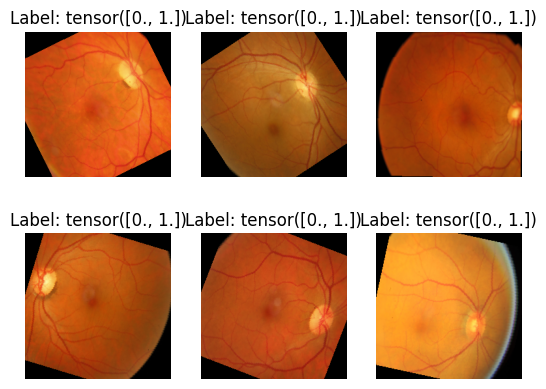

In [ ]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [ ]:
# Create the model
# backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
backbone_model = byol_model.backbone
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [ ]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 61/61 [00:18<00:00,  3.38it/s]


Epoch 1, Train Loss: 0.5474252680609568, Val Loss: 0.452745364337671, F1 Score: 0.6346765888310906


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 2, Train Loss: 0.4656111916129509, Val Loss: 0.3693240751497081, F1 Score: 0.7723046158973504


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 3, Train Loss: 0.44138499152626887, Val Loss: 0.39059665225079804, F1 Score: 0.6784759810370292


100%|██████████| 61/61 [00:17<00:00,  3.41it/s]


Epoch 4, Train Loss: 0.42146738235618963, Val Loss: 0.31760495375902925, F1 Score: 0.7939885173927728


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 5, Train Loss: 0.39658222676076915, Val Loss: 0.30209411216563864, F1 Score: 0.806554958783755


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 6, Train Loss: 0.38214322419711544, Val Loss: 0.28869548476621754, F1 Score: 0.8875368731563422


100%|██████████| 61/61 [00:18<00:00,  3.35it/s]


Epoch 7, Train Loss: 0.3671895475702339, Val Loss: 0.3085082928176786, F1 Score: 0.834810687392766


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 8, Train Loss: 0.35189290663876227, Val Loss: 0.32651353297663516, F1 Score: 0.8829495614035088


100%|██████████| 61/61 [00:18<00:00,  3.38it/s]


Epoch 9, Train Loss: 0.33863998677455975, Val Loss: 0.26558674725352743, F1 Score: 0.8644444444444445


100%|██████████| 61/61 [00:18<00:00,  3.35it/s]


Epoch 10, Train Loss: 0.31270948902630574, Val Loss: 0.27490678594493473, F1 Score: 0.8829495614035088


100%|██████████| 61/61 [00:18<00:00,  3.28it/s]


Epoch 11, Train Loss: 0.3158449129845026, Val Loss: 0.24780723354855522, F1 Score: 0.8908329738107792


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 12, Train Loss: 0.2907778134130025, Val Loss: 0.2569890814360048, F1 Score: 0.9011061386473022


100%|██████████| 61/61 [00:18<00:00,  3.36it/s]


Epoch 13, Train Loss: 0.2851622479763719, Val Loss: 0.2200182347146214, F1 Score: 0.8484963944512651


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 14, Train Loss: 0.27045107947589225, Val Loss: 0.23794592324583258, F1 Score: 0.8019870155420028


100%|██████████| 61/61 [00:17<00:00,  3.39it/s]


Epoch 15, Train Loss: 0.2623839697047147, Val Loss: 0.24638192392274982, F1 Score: 0.8876856595253306


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 16, Train Loss: 0.22844845249338516, Val Loss: 0.22132026373607214, F1 Score: 0.907488569223339


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 17, Train Loss: 0.21886073262953942, Val Loss: 0.24913851092340517, F1 Score: 0.8783213689650319


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 18, Train Loss: 0.2951763759189275, Val Loss: 0.45151555770244756, F1 Score: 0.7449559201749439


100%|██████████| 61/61 [00:18<00:00,  3.36it/s]


Epoch 19, Train Loss: 0.3042078554797708, Val Loss: 0.2575602096612336, F1 Score: 0.8675161466885606


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 20, Train Loss: 0.2220788508695498, Val Loss: 0.15592596939474831, F1 Score: 0.8845789971617786


100%|██████████| 61/61 [00:18<00:00,  3.30it/s]


Epoch 21, Train Loss: 0.19210713193621068, Val Loss: 0.15966574582042264, F1 Score: 0.9072116795562297
Early stopping triggered.


### Test

100%|██████████| 244/244 [01:09<00:00,  3.52it/s]


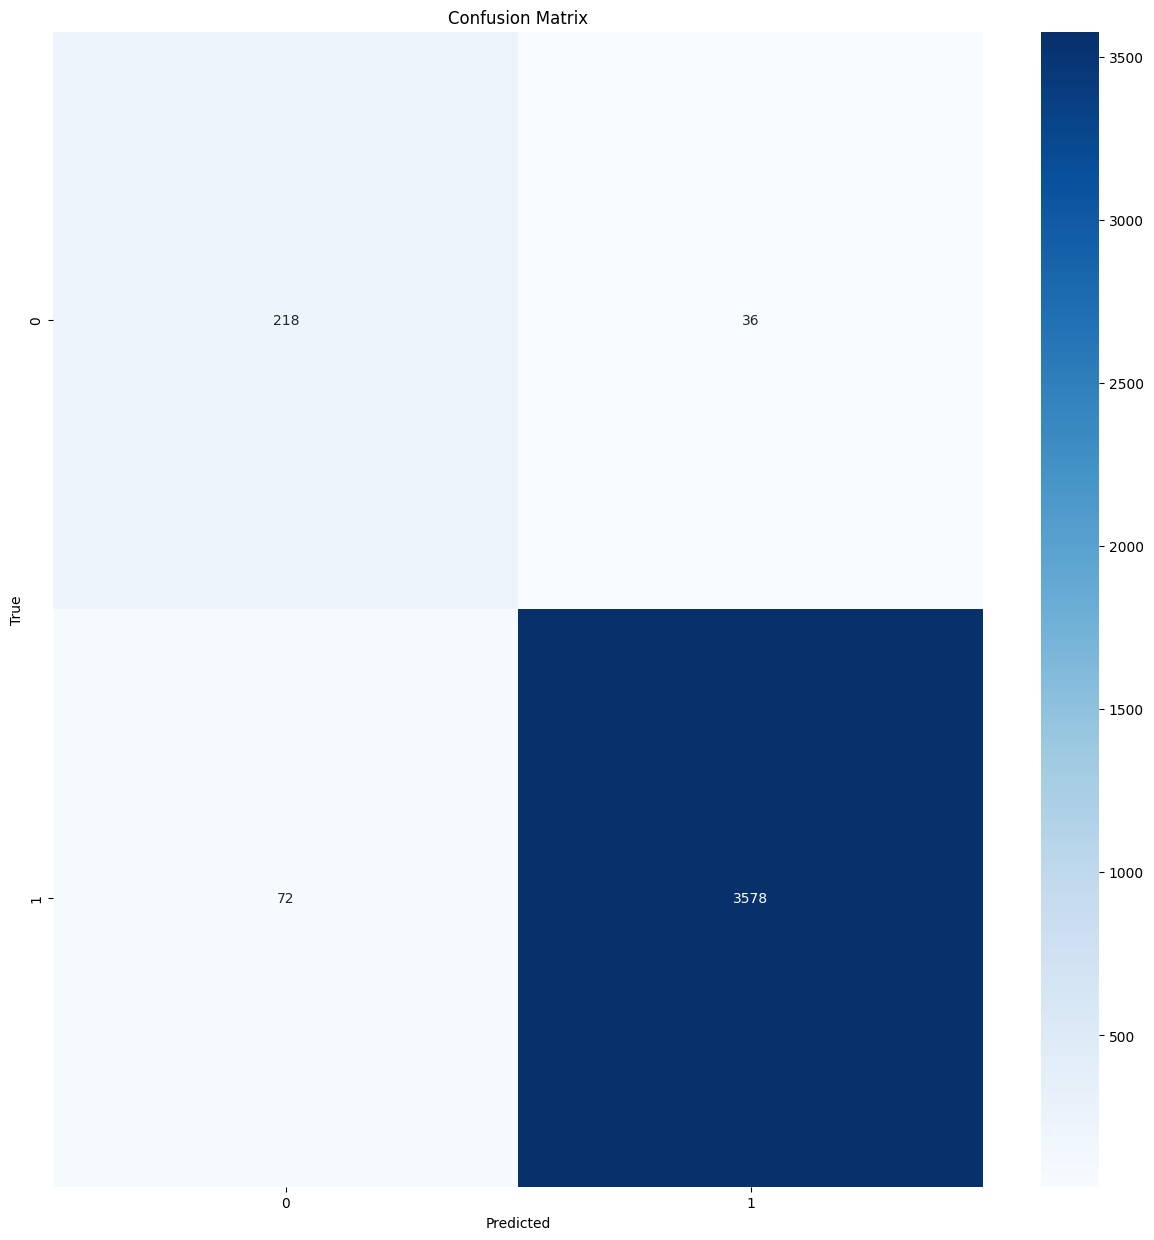

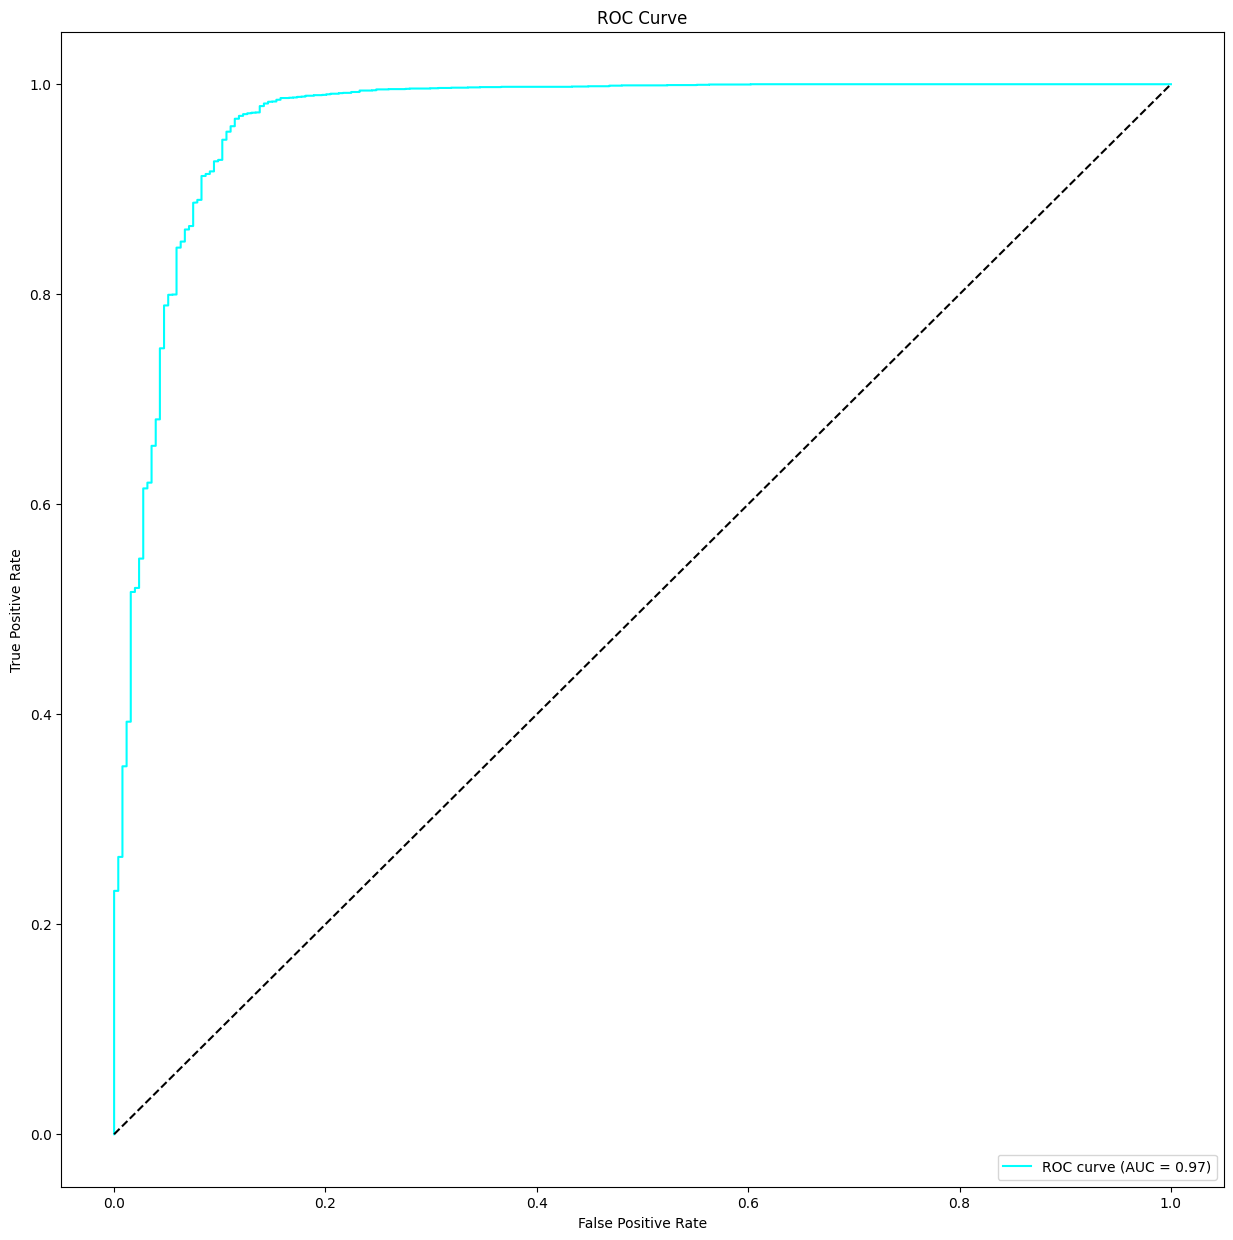

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       254
           1       0.99      0.98      0.99      3650

    accuracy                           0.97      3904
   macro avg       0.87      0.92      0.89      3904
weighted avg       0.97      0.97      0.97      3904

##################################################  Saliency Maps  ##################################################

Class 0:


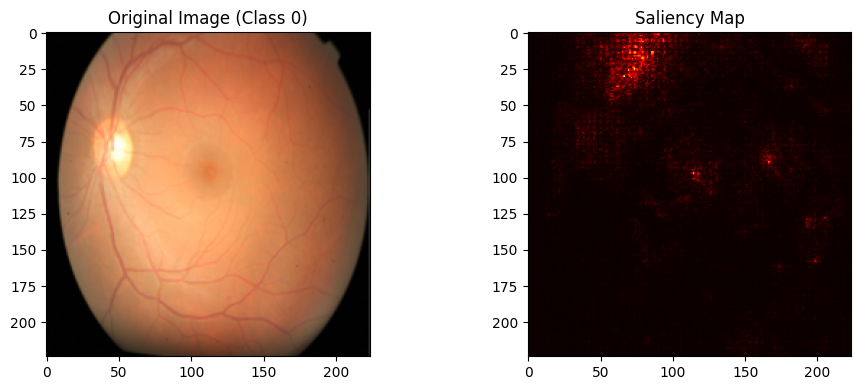

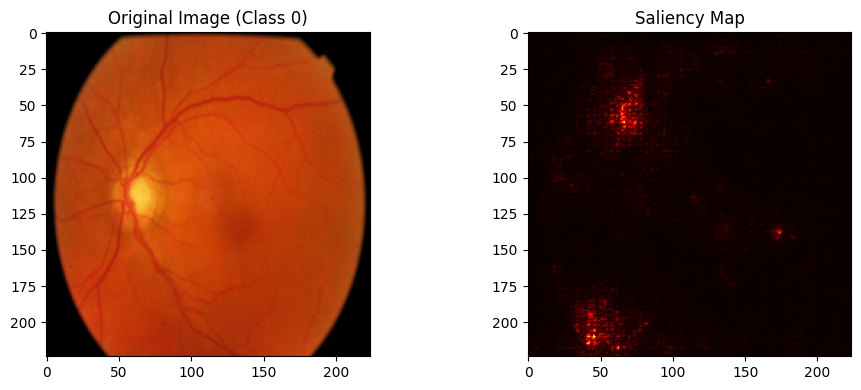

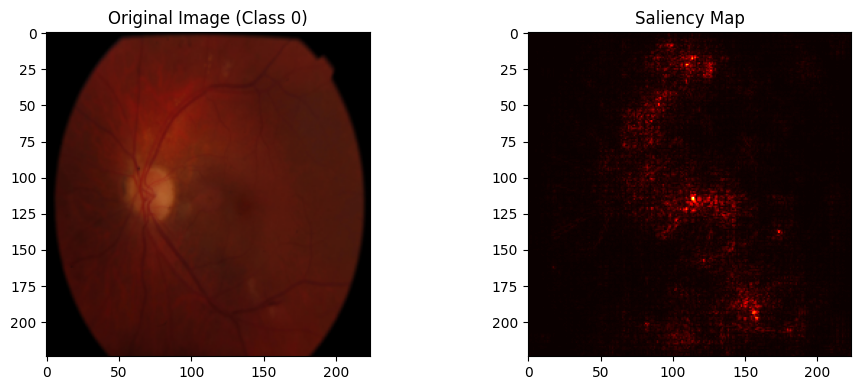

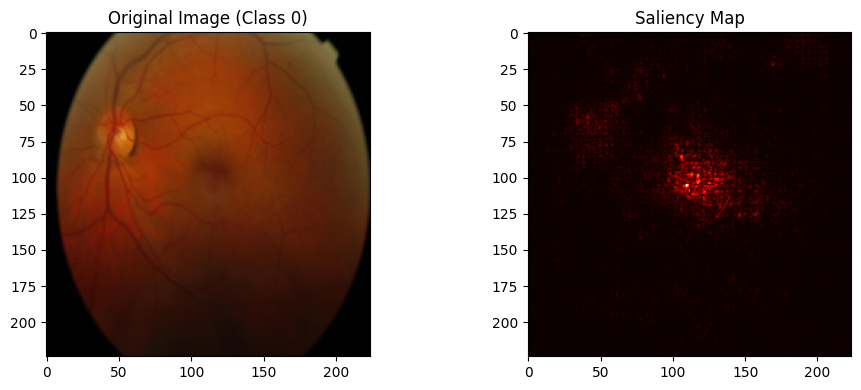

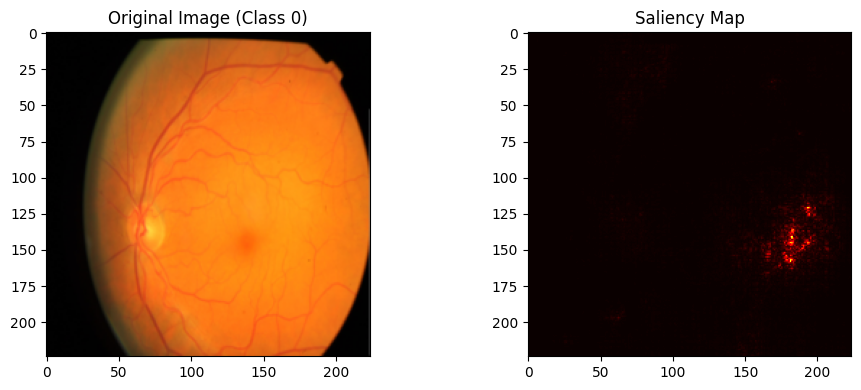

Class 1:


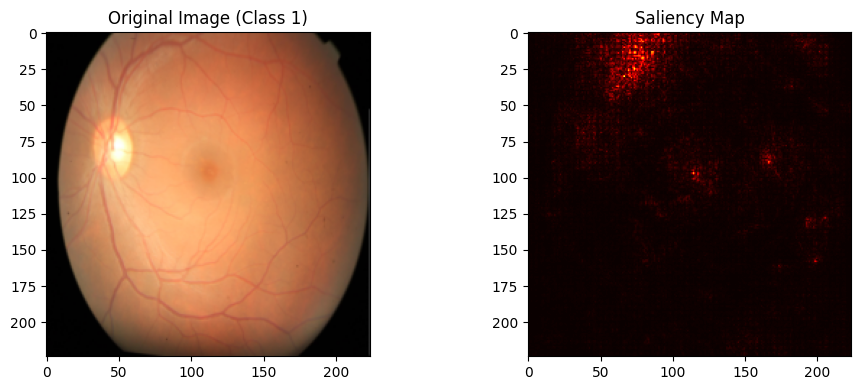

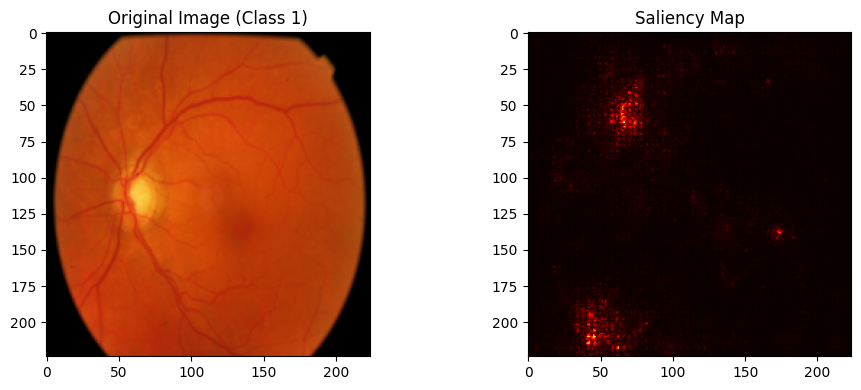

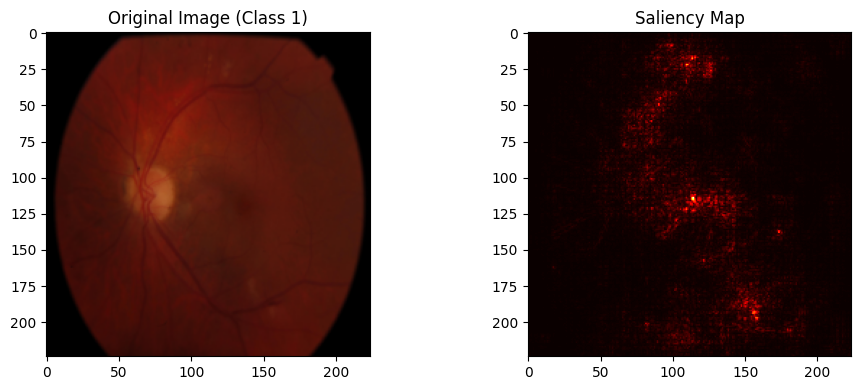

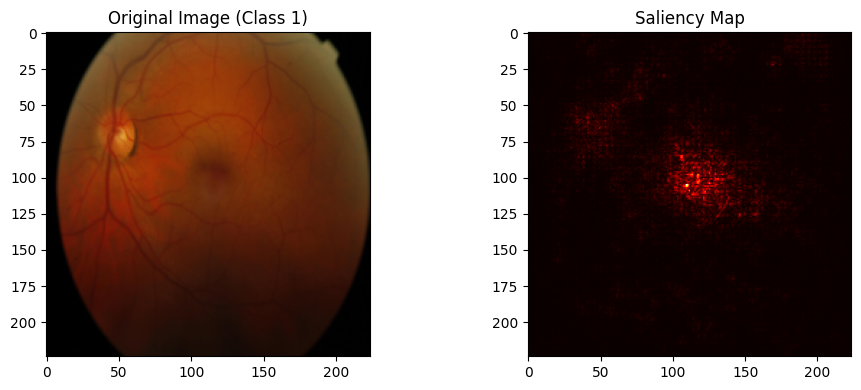

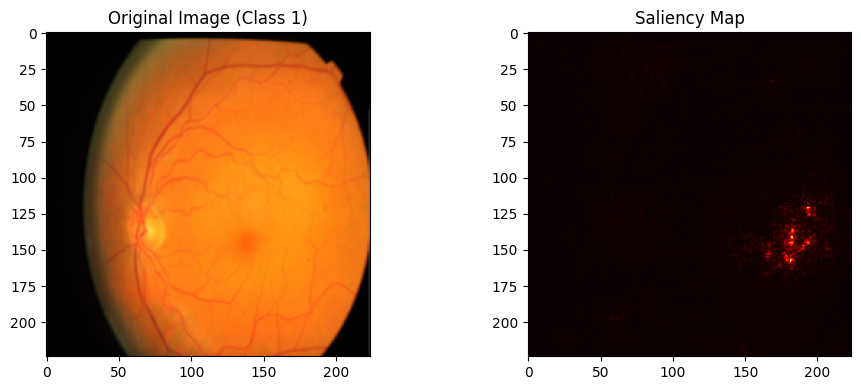

In [ ]:
test(model, test_dataloader, saliency=True, device=device)